<a href="https://colab.research.google.com/github/arthurgivigir/infnet_pd_25E2-25E2/blob/main/Arthur_Givigir_1905_Question%C3%A1rio_Projeto_de_Disciplina_de_Text_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Disciplina de Processamento de Linguagem Natural com Python

Bem-vindo ao projeto de disciplina de **Processamento de Linguagem Natural com Python**. Ao longo das últimas aulas vimos uma série de aplicações que nos deram a amplitude de possibilidades em trabalhar com textos. Para tal, usamos diversas bibliotecas, onde as que mais se destacaram foram NLTK, SPACY e GENSIM.

Esse notebook servirá de guia para a execução de uma análise de tópicos completa, usando o algoritmo de LDA e recursos para interpretação dos resultados. Utilizaremos notícias da seção "Mercado" extraídas da Folha de S. Paulo no ano de 2016.  Complete a análise com os códigos que achar pertinente e responda as questões presentes no Moodle. Boa sorte!

## O Notebook

Nesse notebook, você será guiado pela análise de **Extração de Tópicos**. As seguintes tarefas serão realizadas


1.   Download dos dados provenientes do kaggle
2.   Seleção dos dados relevantes para a nossa análise
3.   Instalação das principais ferramentas e importação de módulos
4.   Pré-processamento usando NLTK
5.   Pré-processamento usando Spacy
6.   Análise de tópicos usando LDA
7.   Análise de NER usando Spacy
8.   Visualização dos tópicos usando tokens e entidades.



## Instruções para baixar os dados

Para baixar os dados será necessário o uso do gerenciador de downloads da Kaggle. A Kaggle, uma subsidiária do grupo Alphabet (Google), é uma comunidade on-line de cientistas de dados e profissionais de aprendizado de máquina.

Para utilizar o gerenciador, será necessário criar uma conta no site Kaggle.com.
Com a conta criada, obtenha um token de acesso, no formato kaggle.json

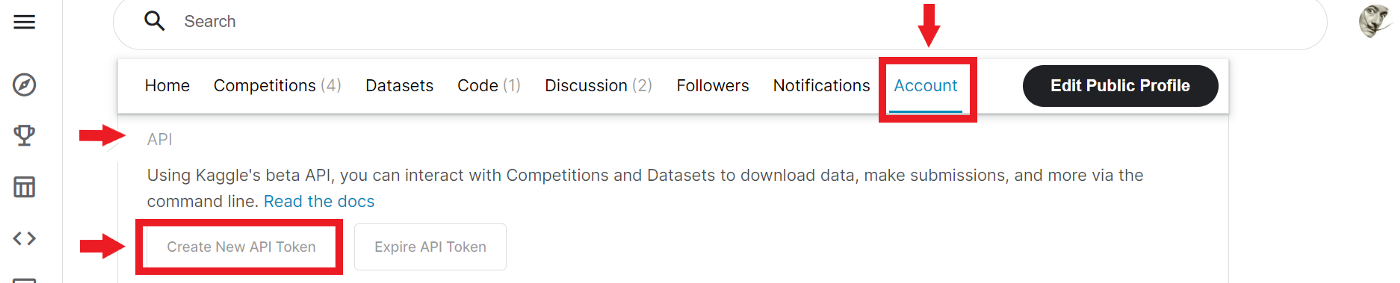

Em posse do token (baixe para seu computador), execute a células da próxima seção para acessar os dados de interesse e baixá-los.

# Baixe os dados

Instale o gerenciador kaggle no ambiente do Colab e faça o upload do arquivo kaggle.json

In [ ]:
!pip install -q kaggle
!rm -rf kaggle.json
from google.colab import files

files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arthurgivigir","key":"3798caf33b649ac6f5577df6da6dff76"}'}

Crie a pasta .kaggle

In [ ]:
# !rm -rf .kaggle
# !mkdir .kaggle
# !cp kaggle.json .kaggle/
# !chmod 600 .kaggle/kaggle.json

!rm -rf .kaggle
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Baixe o dataset

In [ ]:
!kaggle datasets download --force -d marlesson/news-of-the-site-folhauol

Dataset URL: https://www.kaggle.com/datasets/marlesson/news-of-the-site-folhauol
License(s): CC0-1.0
 77% 144M/187M [00:00<00:00, 422MB/s] 
100% 187M/187M [00:00<00:00, 448MB/s]


## Criar o DataFrame com os dados lidos diretamente da plataforma Kaggle

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()


df = pd.read_csv("news-of-the-site-folhauol.zip")

# Atualizar o SPACY e  instalar os modelos pt_core_news_lg

In [ ]:
!pip install -U spacy
!python -m spacy download pt_core_news_lg

import spacy
from spacy.lang.pt.stop_words import STOP_WORDS


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 64.8 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.8.5
    Uninstalling spacy-3.8.5:
      Successfully uninstalled spacy-3.8.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 3.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Instalar os datasets `stopwords`, `punkt` e `rslp` do nltk

In [ ]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

## Carregar os módulos usados ao longo desse notebook

In [ ]:
!pip install pyldavis &> /dev/null

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np

from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

from typing import List, Set, Any


SEED = 123

# Filtrando os dados para utilizar apenas as notícias do ano de 2016 e da categoria "Mercado"

Filtre os dados do DataFrame df e crie um DataFrame news_2016 que contenha apenas notícias de **2016** e da categoria **mercado**.

In [ ]:
df['date'] = pd.to_datetime(df.date)
# Create a dataframe named news_2016
news_2016 = df[(df['date'].dt.year == 2016) & (df['category'] == 'mercado')]
print(news_2016['title'].count)

<bound method Series.count of 34207    Fazendeira cria própria rede de banda larga e ...
34238    Alteração na cobrança do ICMS eleva conta de c...
34245    Ajustes sobre servidores públicos emperram nos...
34248    Inventor da internet das coisas ataca mitos so...
34249    Livro analisa empresas de crescimento exponenc...
                               ...                        
94280    Previsões para economia dependem de rumos do g...
94295    Repelentes e água de coco lideram a lista de s...
94301    Renda em queda leva mais pessoas às filas de e...
94310    Brasil pode perder até 2,2 milhões de vagas fo...
94314    Usina nuclear Angra 3 procura verba e saídas p...
Name: title, Length: 7943, dtype: object>


## NLTK Tokenizer and Stemmer

Crie uma coluna no dataframe `news_2016` contendo os tokens para cada um dos textos. Os tokens devem estar representados pelo radical das palavras (stem).
Para tal, complete o conteúdo da função `tokenize`.

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer

stopwords_pt = set(stopwords.words('portuguese'))
stemmer = RSLPStemmer()

def tokenize(text: str) -> List:
  """
  Function for tokenizing using `nltk.tokenize.word_tokenize`

  Returns:
    - A list of stemmed tokens (`nltk.stem.RSLPStemmer`)
    IMPORTANT: Only tokens with alphabetic
               characters will be returned.
  """
  tokens = word_tokenize(text.lower(), language='portuguese')
  filtered_tokens = [t for t in tokens if t.isalpha() and t not in stopwords_pt]
  stems = [stemmer.stem(t) for t in filtered_tokens]
  return stems

news_2016.loc[:, 'nltk_tokens'] = news_2016.text.progress_map(tokenize)

  0%|          | 0/7943 [00:00<?, ?it/s]

## Criar uma documento SPACY para cada texto do dataset

Crie uma coluna `spacy_doc` que contenha os objetos spacy para cada texto do dataset de interesse. Para tal, carregue os modelos `pt_core_news_lg` e aplique em todos os textos (pode demorar alguns minutos...)

In [ ]:
nlp = spacy.load("pt_core_news_lg")
news_2016.loc[:, 'spacy_doc'] = news_2016['text'].progress_map(nlp)

  0%|          | 0/7943 [00:00<?, ?it/s]

## Realize a Lematização usando SPACY

O modelo NLP do spacy oferece a possiblidade de lematizar textos em português (o que não acontece com a biblioteca NLTK). Iremos criar uma lista de tokens
lematizados para cada texto do nosso dataset. Para tal, iremos retirar as
stopwords, usando uma função que junta stopwords provenientes do NLTK e do Spacy. Essa lista completa, é retornada pela função stopwords (e você não precisa mexer).

Já a função filter retorna True caso o token seja composto por caracters alfabéticos, não estiver dentro da lista de stopwords e o lemma resultante não estiver contido na lista `o", "em", "em o", "em a" e "ano"`.

Crie uma coluna chamada `spacy_lemma` para armazenar o resultado desse pré-processamento.

In [ ]:
def stopwords() -> Set:
    """
    Return complete list of stopwords
    """
    return set(list(nltk.corpus.stopwords.words("portuguese")) + list(STOP_WORDS))

complete_stopwords = stopwords()

def filter(w: spacy.lang.pt.Portuguese) -> bool:
    """
    Filter stopwords and undesired tokens
    """
    custom_stopwords = ["o", "em", "em o", "em a", "ano", "de o", "por o", "de este", "em este", "a o", "outro", "esse", "disse"]
    return w.is_alpha and w.lemma_.lower() not in complete_stopwords and w.lemma_.lower() not in custom_stopwords


def lemma(doc: spacy.lang.pt.Portuguese) -> List[str]:
    """
    Apply spacy lemmatization on the tokens of a text

    Returns:
       - a list representing the standardized (with lemmatisation) vocabulary
    """
    return [w.lemma_.lower() for w in doc if filter(w)]

news_2016.loc[:, 'spacy_lemma'] = news_2016.spacy_doc.progress_map(lemma)

  0%|          | 0/7943 [00:00<?, ?it/s]

In [ ]:
news_2016.loc[:, 'spacy_lemma']

,spacy_lemma
34207,"[mulher, fazendeiro, christine, conder, modést..."
34238,"[conta, celular, controle, ficar, cara, decisã..."
34245,"[projeto, ajuste, conta, público, aprovar, mau..."
34248,"[década, século, nota, ópera, sinfonia, brotar..."
34249,"[cifras, letras, selecionar, semanalmente, lan..."
...,...
94280,"[economista, rodolfo, margato, banco, santande..."
94295,"[conveniência, saúde, prazer, tendência, consu..."
94301,"[rendimento, queda, pessoa, forçar, buscar, fi..."
94310,"[brasil, perder, milhão, vaga, carteira, assin..."


## Reconhecimento de entidades nomeadas

Crie uma coluna `spacy_ner` que armazene todas as organizações (APENAS organizações) que estão contidas no texto.

In [ ]:
def NER(doc: spacy.lang.pt.Portuguese):
  """
  Return the list of organizations for a SPACY document
  """
  return [w.text for w in doc.ents if w.label_ == 'ORG']

news_2016.loc[:, 'spacy_ner'] = news_2016.spacy_doc.progress_map(NER)

  0%|          | 0/7943 [00:00<?, ?it/s]

In [ ]:
news_2016.loc[:, 'spacy_ner']

,spacy_ner
34207,"[Gbps, Ofcom, Cavamos, Membro da, Ordem do Imp..."
34238,"[Oi, TIM, Claro, Vivo, Secretaria de Estado da..."
34245,"[Executivo dos três Estados, Executivo, Assemb..."
34248,"[MIT, Instituto de Tecnologia de Massachusetts..."
34249,"[Singularity University, Sistema Financeiro Na..."
...,...
94280,"[Santander, FGV, Ibre]"
94295,"[Nielsen, Nielsen, MAS NÃO QUEBRAM -, Nielsen,..."
94301,"[Jovens, LCA, LCA]"
94310,"[LCA Consultores, GO Associados, PROCURA, Pnad..."


## Bag-of-Words

Crie uma coluna `tfidf` no dataframe `news_2016`. Use a coluna `spacy_lemma` como base para cálculo do TFIDF.
O número máximo de features que iremos considerar é 5000. E o token, tem que ter aparecido pelo menos 10 vezes (`min_df`) nos documentos.

In [ ]:
class Vectorizer:
  def __init__(self, doc_tokens: List):
    self.doc_tokens = doc_tokens
    self.tfidf = None


  def vectorizer(self):
      """
      Convert a list of tokens to tfidf vector
      Returns the tfidf vector and attribute it to self.tfidf
      """
      strings_docs = [' '.join(doc) for doc in self.doc_tokens]
      vectorizer = TfidfVectorizer(max_features=5000, min_df=10)
      self.tfidf = vectorizer.fit(strings_docs)
      self.tfidf = vectorizer
      return self.tfidf

  def __call__(self):
    if self.tfidf is None:
        self.vectorizer()
    return self.tfidf

doc_tokens = news_2016.spacy_lemma.values.tolist()
vectorizer = Vectorizer(doc_tokens)

def tokens2tfidf(tokens):
    tokens = ' '.join(tokens)
    array =  vectorizer().transform([tokens]).toarray()[0]
    return array


news_2016.loc[:, 'tfidf'] = news_2016.spacy_lemma.progress_map(tokens2tfidf)

  0%|          | 0/7943 [00:00<?, ?it/s]

## Extração de Tópicos

Realize a extração de 9 tópicos usando a implementação do sklearn do algoritmo Latent Dirichlet Allocation. Como parâmetros, você irá usar o número máximo de iterações igual à 100 (pode demorar) e o `random_seed` igual a `SEED` que foi setado no início do notebook

In [ ]:
N_TOKENS = 9

corpus = np.array(news_2016.tfidf.tolist())

from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=N_TOKENS, max_iter=100, random_state=SEED)
lda.fit(corpus)

LatentDirichletAllocation(max_iter=100, n_components=9, random_state=123)

### Atribua a cada text, um (e apenas um) tópic.

Crie uma coluna `topic` onde o valor é exatamente o tópico que melhor caracteriza o documento de acordo com o algoritmo de LDA.

In [ ]:
def get_topic(tfidf: np.array):
    """
    Get topic for a lda trained model
    """
    topics = lda.transform([tfidf])
    return np.argmax(topics) + 1

news_2016['topic'] = news_2016.tfidf.progress_map(get_topic)

  0%|          | 0/7943 [00:00<?, ?it/s]

## Número de documentos vs tópicos

Esse gráfico nos mostra quantos documentos foram caracterizados por cada tópico.

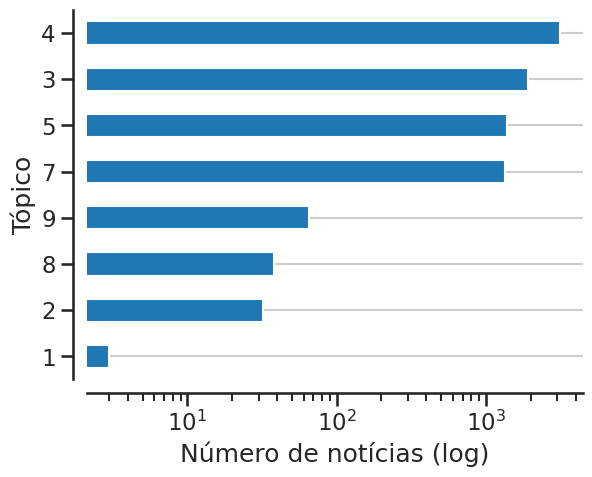

In [ ]:
with sns.axes_style("ticks"):
    sns.set_context("talk")
    ax = news_2016['topic'].value_counts().sort_values().plot(kind = 'barh')
    ax.yaxis.grid(True)
    ax.set_ylabel("Tópico")
    ax.set_xlabel("Número de notícias (log)")
    sns.despine(offset = 10)
    ax.set_xscale("log")

## Crie uma nuvem de palavra para cada tópico.

Use as colunas `spacy_lemma` e  `topic` para essa tarefa.

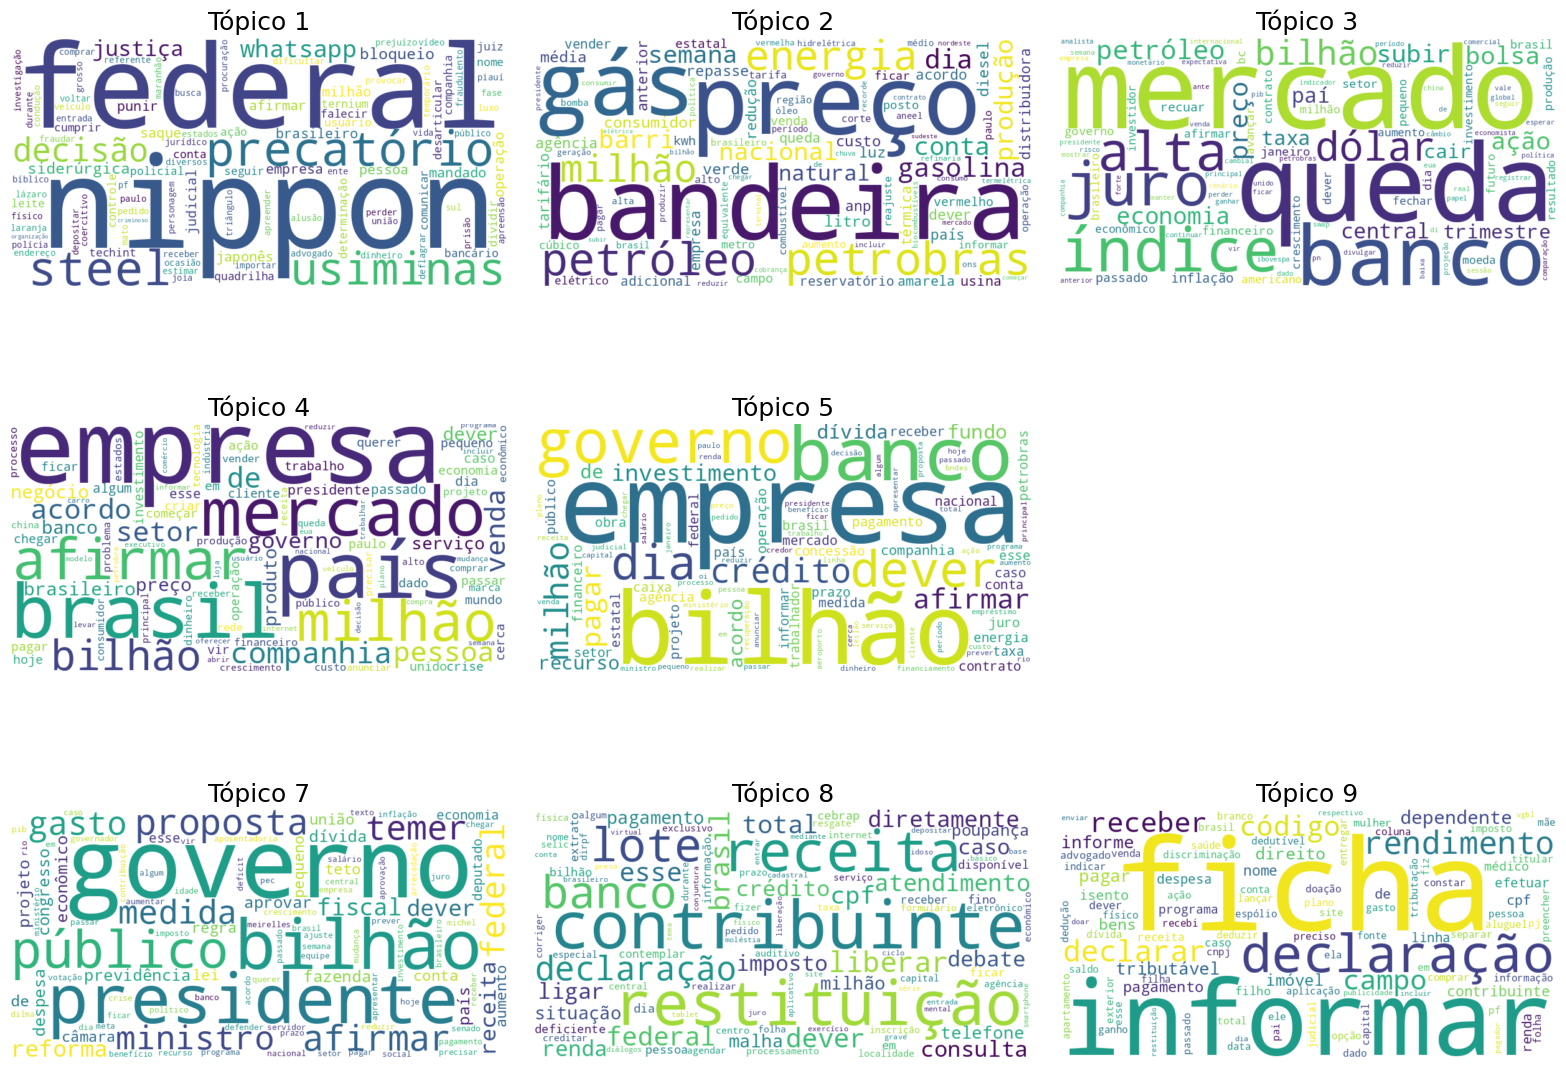

In [ ]:
def plot_wordcloud(text:str, ax:plt.Axes) -> plt.Axes:
    """
    Plot the wordcloud for the text/
    Arguments:
        -  text: string to be analised
        -  ax: plt subaxis
    Returns:
     - ax
    """
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100,
        colormap='viridis',
        collocations=False
    ).generate(text)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    return ax

def plot_wordcloud_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_words = chain(*topic_news.spacy_lemma.values.tolist())
    string_complete = ' '.join(list_of_words)
    if not string_complete:
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()

## Crie uma nuvem de entidades para cada tópico.

Use as colunas `spacy_lemma` e  `topic` para essa tarefa.

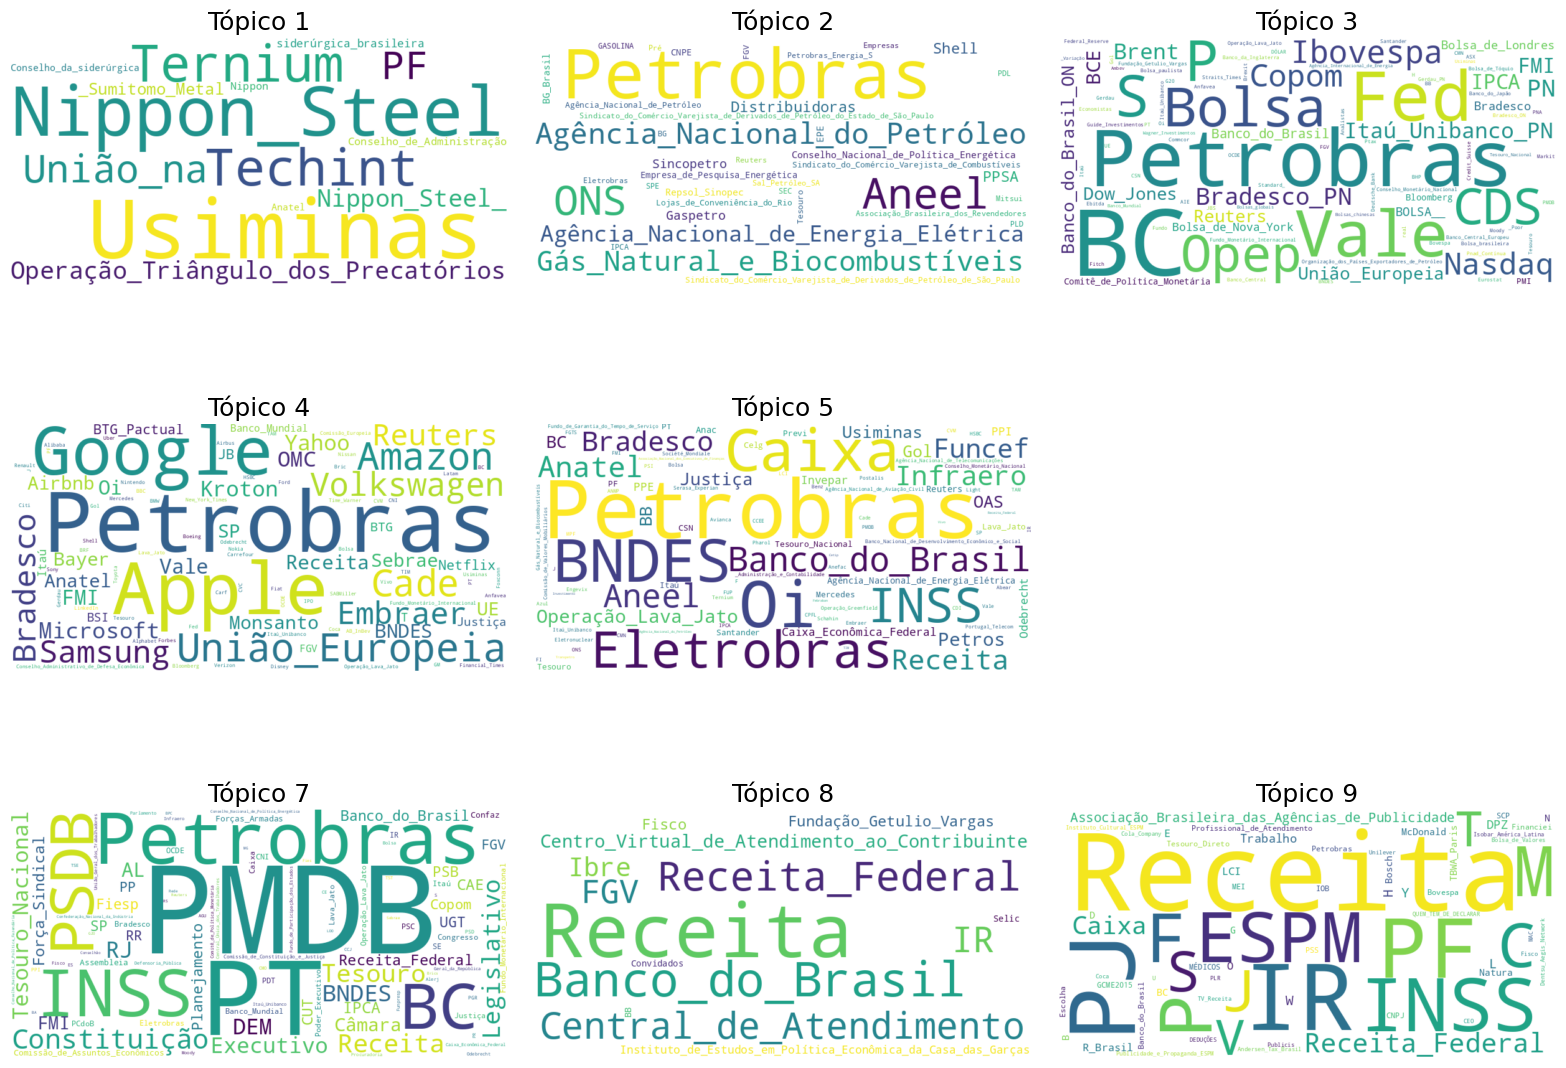

In [ ]:
def plot_wordcloud_entities_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_docs = topic_news.spacy_ner.apply(lambda l : [w.replace(" ", "_") for w in l])
    list_of_words = chain(*list_of_docs)
    string_complete = ' '.join(list_of_words)
    if not len(string_complete):
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_entities_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()